<a href="https://colab.research.google.com/github/etgins/Mice_ASD_Detection/blob/main/final_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

----------------------------------------------
Written by Itamar Ginsberg & Alon Schreuer, November 2021


Imports and setup
----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time
import os
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import xgboost as xgb
import itertools 


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Ridge, Lasso

from sklearn.model_selection import GridSearchCV

In [ ]:
# plot confusion matrix
def plot_confusion_matrix(cnf_matrix, numbers_type='normalized', class_names=[], title='Confusion matrix', cmap=plt.cm.Blues, file_name='confusionmatrix.png'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    combined = True
    cnf_matrix_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    if numbers_type == 'normalized':
        cnf_matrix_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cnf_matrix)
    plt.figure()
    plt.figure(figsize=(5,5))
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar(plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap),shrink=0.80)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    

    thresh = 0.8*cnf_matrix.max() / 1.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        if numbers_type == 'numbers_and_percentage':
            st1 = '{:.2f}%'.format(100 * cnf_matrix_normalized[i, j])
            st2 = '({:2d})'.format(cnf_matrix[i, j])
            plt.text(j, i, st1+st2,
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black", fontsize=18)

        elif numbers_type == 'percentage':
            fmt = '.2f'
            plt.text(j, i, format(cnf_matrix_normalized[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black",fontsize=18)
        else:
            fmt = 'd'
            plt.text(j, i, format(cnf_matrix[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black",fontsize=18)

    plt.tight_layout()
    plt.ylabel('True label',fontsize=18)
    plt.xlabel('Predicted label',fontsize=18)
    #fig = plt.gcf()
    plt.savefig(file_name)

    return

Data and pre-process
----

In [ ]:
col_names = ['syll1_s_freq','syll2_s_freq','syll3_s_freq','syll4_s_freq','syll5_s_freq','syll6_s_freq','syll7_s_freq','syll8_s_freq','syll9_s_freq','syll10_s_freq',
            'syll1_e_freq','syll2_e_freq','syll3_e_freq','syll4_e_freq','syll5_e_freq','syll6_e_freq','syll7_e_freq','syll8_e_freq','syll9_e_freq','syll10_e_freq',
            'syll1_dist','syll2_dist','syll3_dist','syll4_dist','syll5_dist','syll6_dist','syll7_dist','syll8_dist','syll9_dist','syll10_dist',
            'syll1_dur','syll2_dur','syll3_dur','syll4_dur','syll5_dur','syll6_dur','syll7_dur','syll8_dur','syll9_dur','syll10_dur',
             'mother_gen',
             'pup_sex',
             'avg_ISI_time','pup_age','session','pup_strain',
             'pup_gen',
             'mouse_idx'
]

# load data from xls/csv file
dataset = pd.read_csv("/content/drive/MyDrive/final_project/final_classification/ALL_DATA/processed_data_for_final_classification_REDUCTION_BY_RECORDING_ALLDATA.csv", header=None, names=col_names)
# dataset.info()

X = dataset.iloc[:,:-2]
y = dataset.iloc[:,-2]
groupsM = dataset.iloc[:,-1]

In [ ]:
# pre-process data:
  # normalize - different magnitudes between features (!!!)

# print(X.iloc[0,0:5])
# scaler = StandardScaler().fit(X)
# print(scaler.mean_)
# print(scaler.var_)
# print(scaler.scale_)
# X_scaled = scaler.transform(X)
# print(X_scaled[0,0:5])

XGBoost - useful sources:
------------
✅ 1. https://towardsdatascience.com/running-xgboost-on-google-colab-free-gpu-a-case-study-841c90fef101

2. https://towardsdatascience.com/ensemble-learning-and-model-interpretability-a-case-study-95141d75a96c

✅3. https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d
- good conceptual explanation of the evolution of decision trees and XGBoost

✅4. https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7
- Gradient boosting for decision trees:
  - ensemble method, iteratively creating new trees, each focused on correcting the previous tree's mistakes (each model is trained on the so-far model's errors).


5. https://towardsdatascience.com/a-journey-through-xgboost-milestone-2-f3410109be5a
6. Official XGBoost website: https://xgboost.readthedocs.io/en/latest/parameter.html

✅7. Tune Learning Rate for Gradient Boosting - https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/

run XGBoost
---

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 6.68 µs
Train Accuracy:  0.79991584262571
Test Accuracy:  0.7665615141955836
Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.94      0.72       501
         1.0       0.96      0.68      0.80      1084

    accuracy                           0.77      1585
   macro avg       0.77      0.81      0.76      1585
weighted avg       0.84      0.77      0.77      1585



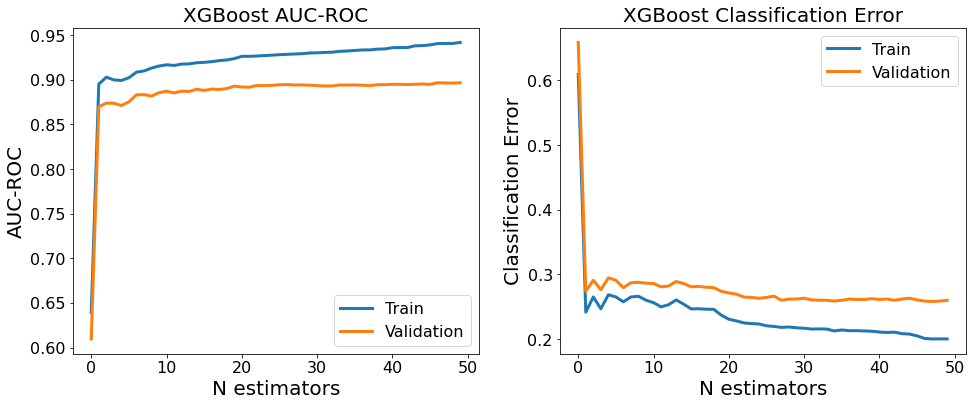


 Confusion Matrix:
Confusion matrix, without normalization


<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

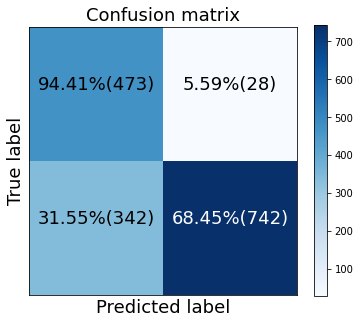

In [ ]:
seed = 100

# split the clean_X into train and test sets

X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.25, random_state=seed, shuffle=True)


import time
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
# create an XGBoost classifier
#model = XGBClassifier(n_estimators=50, random_state=seed, learning_rate=1, max_depth=10, objective='binary:logistic', booster='gbtree', feval='rmsle',
#                      subsample= 0.8, reg_lambda = 0.1, reg_alpha = 0.1, min_child_weight = 0.1, scale_pos_weight = 1/2.08, colsample_bytree = 0.6, tree_method = 'exact')

# ARCHIVE: 88% accuracy was reached with: 
model = XGBClassifier(n_estimators=50, random_state=seed, learning_rate=0.1, max_depth=5, objective='binary:logistic', booster='gbtree', feval='rmsle',
                      reg_lambda = 1.5, reg_alpha = 0.05, min_child_weight = 0.1, scale_pos_weight = 0.8, colsample_bytree = 0.6)


    
# define the eval set and metric
eval_set = [(X_train, y_train), (X_val, y_val)]
eval_metric = ["auc","error"]

# fit the model
%time
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
model.fit(X_train, y_train, sample_weight=sample_weights, eval_metric=eval_metric, eval_set=eval_set, verbose=False)



from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# model assessment
pred_train = model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))

pred_test = model.predict(X_test)
print('Test Accuracy: ', accuracy_score(y_test, pred_test))

print('Classification Report:')
print(classification_report(y_test,pred_test,zero_division=0))



# CHECK ACCURACY MANUALLY TO BE SURE AND LOOK AT SOME RESULTS:
# print('calculate accuracy manually:', '\n')
# print('accuracy vec: ', accuracy_vec, 'true labels: ', y_test)
# train_accuracy_vec = pred_train == y_train
# test_accuracy_vec = pred_test == y_test
# print('train test accuracy is:', np.round(train_accuracy_vec.sum()/len(train_accuracy_vec), 3))
# print('manual test accuracy is:', np.round(test_accuracy_vec.sum()/len(test_accuracy_vec), 3))



# retrieve performance metrics and plot AUC-ROC and classification error
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(1, 2, figsize=(16,6))
# plot auc
ax[0].plot(x_axis, results['validation_0']['auc'], label='Train', linewidth=3)
ax[0].plot(x_axis, results['validation_1']['auc'], label='Validation',linewidth=3)
ax[0].legend()
ax[0].set_title('XGBoost AUC-ROC', fontsize=20)
ax[0].set_ylabel('AUC-ROC', fontsize=20)
ax[0].set_xlabel('N estimators', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[0].legend(fontsize=16) 
# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train',linewidth=3)
ax[1].plot(x_axis, results['validation_1']['error'], label='Validation',linewidth=3)
ax[1].legend()
ax[1].set_title('XGBoost Classification Error', fontsize=20)
ax[1].set_ylabel('Classification Error', fontsize=20)
ax[1].set_xlabel('N estimators', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[1].legend(fontsize=16) 
plt.savefig('/content/drive/MyDrive/final_project/final_classification/AUC_error.png', dpi=200)
plt.show()

plt.tight_layout()


# show confusion matrix
from sklearn.metrics import confusion_matrix
print('\n Confusion Matrix:')
# print(confusion_matrix(y_test,pred_test))
plot_confusion_matrix(confusion_matrix(y_test,pred_test), numbers_type='numbers_and_percentage')



# plot specific trees
plt.rcParams['figure.figsize'] = [15, 10]
#xgb.plot_tree(model,num_trees=0, rankdir='LR')
#xgb.plot_tree(model,num_trees=1, rankdir='LR')
#xgb.plot_tree(model,num_trees=31, rankdir='LR')


# SAVE MODEL TO FILE
import pickle
file_name = "XGBmodel_051221.pkl"
# save
pickle.dump(model, open(file_name, "wb"))
!cp "XGBmodel_051221.pkl" /content/drive/MyDrive/final_project/final_classification

In [ ]:
print(np.array(y_test))

[0. 0. 0. ... 0. 0. 1.]



 Confusion Matrix - New pup:
Confusion matrix, without normalization

 Confusion Matrix - Old pup:
Confusion matrix, without normalization


<Figure size 1080x720 with 0 Axes>

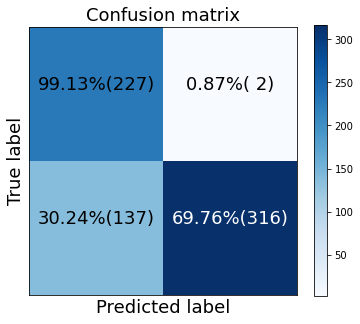

<Figure size 1080x720 with 0 Axes>

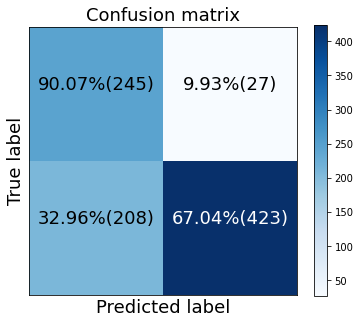

In [ ]:
#result acording strain:
##########################
strain1 = np.where(X_test['pup_strain'] == 1)
strain2 = np.where(X_test['pup_strain'] == 2)
y_test_A = np.array(y_test)

from sklearn.metrics import confusion_matrix
print('\n Confusion Matrix - New pup:')
# print(confusion_matrix(y_test,pred_test))
plot_confusion_matrix(confusion_matrix(y_test_A[strain1[0]],pred_test[strain1[0]]), numbers_type='numbers_and_percentage')
print('\n Confusion Matrix - Old pup:')
plot_confusion_matrix(confusion_matrix(y_test_A[strain2[0]],pred_test[strain2[0]]), numbers_type='numbers_and_percentage')

[[472  29]
 [345 739]]


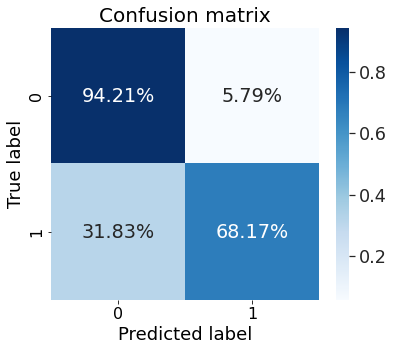

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test,pred_test)
print(cf_matrix)
fig, ax = plt.subplots(figsize=(6, 5))
sns.set(font_scale=1.6)
ax = sns.heatmap(cf_matrix/cf_matrix.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion matrix', fontsize=20);
ax.set_xlabel('Predicted label', fontsize=18);
ax.set_ylabel('True label', fontsize=18);


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
ax.tick_params(axis='both', which='major', labelsize=16)

## Display the visualization of the Confusion Matrix.
plt.savefig('/content/drive/MyDrive/final_project/final_classification/conf_matrix.png', dpi=300)
plt.show()


In [ ]:
# # FINDING THE BEST SCALE_POS_WEIGHT (due to the imbalanced dataset)

# from sklearn.model_selection import RepeatedStratifiedKFold
# # define grid
# weights = [0.8, 1.09]
# param_grid = dict(scale_pos_weight=weights)

# # define evaluation procedure
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define grid search
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# # execute the grid search
# grid_result = grid.fit(X, y)
# # report the best configuration
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# # report all configurations
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.905363 using {'scale_pos_weight': 0.6}
0.905363 (0.009430) with: {'scale_pos_weight': 0.6}
0.905257 (0.009226) with: {'scale_pos_weight': 0.7}
0.905216 (0.009239) with: {'scale_pos_weight': 0.8}
0.904927 (0.009155) with: {'scale_pos_weight': 0.9}
0.904903 (0.009562) with: {'scale_pos_weight': 1}
0.904849 (0.009265) with: {'scale_pos_weight': 1.1}
0.904710 (0.009532) with: {'scale_pos_weight': 1.2}


[1.08842924e-02 7.31459446e-03 1.07974252e-02 1.03837503e-02
 3.96500248e-03 1.07711926e-02 1.77643215e-03 9.46462713e-03
 9.63198580e-03 3.46687925e-03 1.34951398e-02 7.84894451e-03
 1.33865774e-02 1.11808805e-02 5.96512295e-03 8.69418681e-03
 3.72943963e-04 6.59544300e-03 5.41858748e-03 1.12583218e-02
 2.07979139e-02 1.45944003e-02 1.18752262e-02 7.22837122e-03
 8.60881899e-03 1.48808593e-02 4.11445554e-03 5.46275778e-03
 9.63526592e-03 1.26306452e-02 1.20815160e-02 6.27275975e-03
 9.00853705e-03 7.28768297e-03 1.82536934e-02 2.48638168e-02
 0.00000000e+00 5.87126147e-03 4.20188606e-02 6.54690480e-03
 4.71674204e-01 4.49188314e-02 1.03896828e-02 2.30645221e-02
 7.83567131e-03 3.74110565e-02]


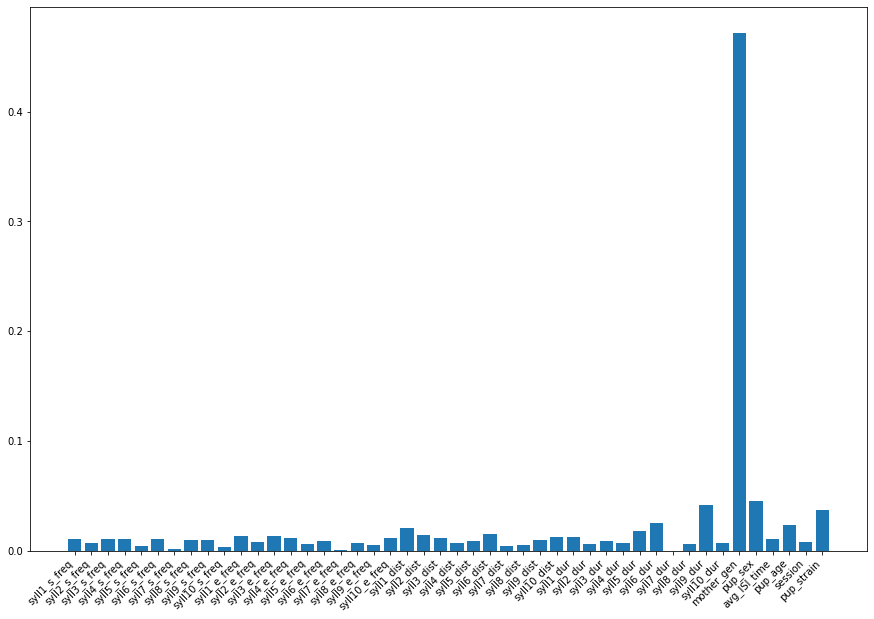

In [ ]:
# PLOT FEATURE IMPORTANCE - MANUALLY
print(model.feature_importances_)

import matplotlib.pyplot as plt
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.xticks(range(len(model.feature_importances_)), col_names, rotation=45, ha="right")
plt.show()

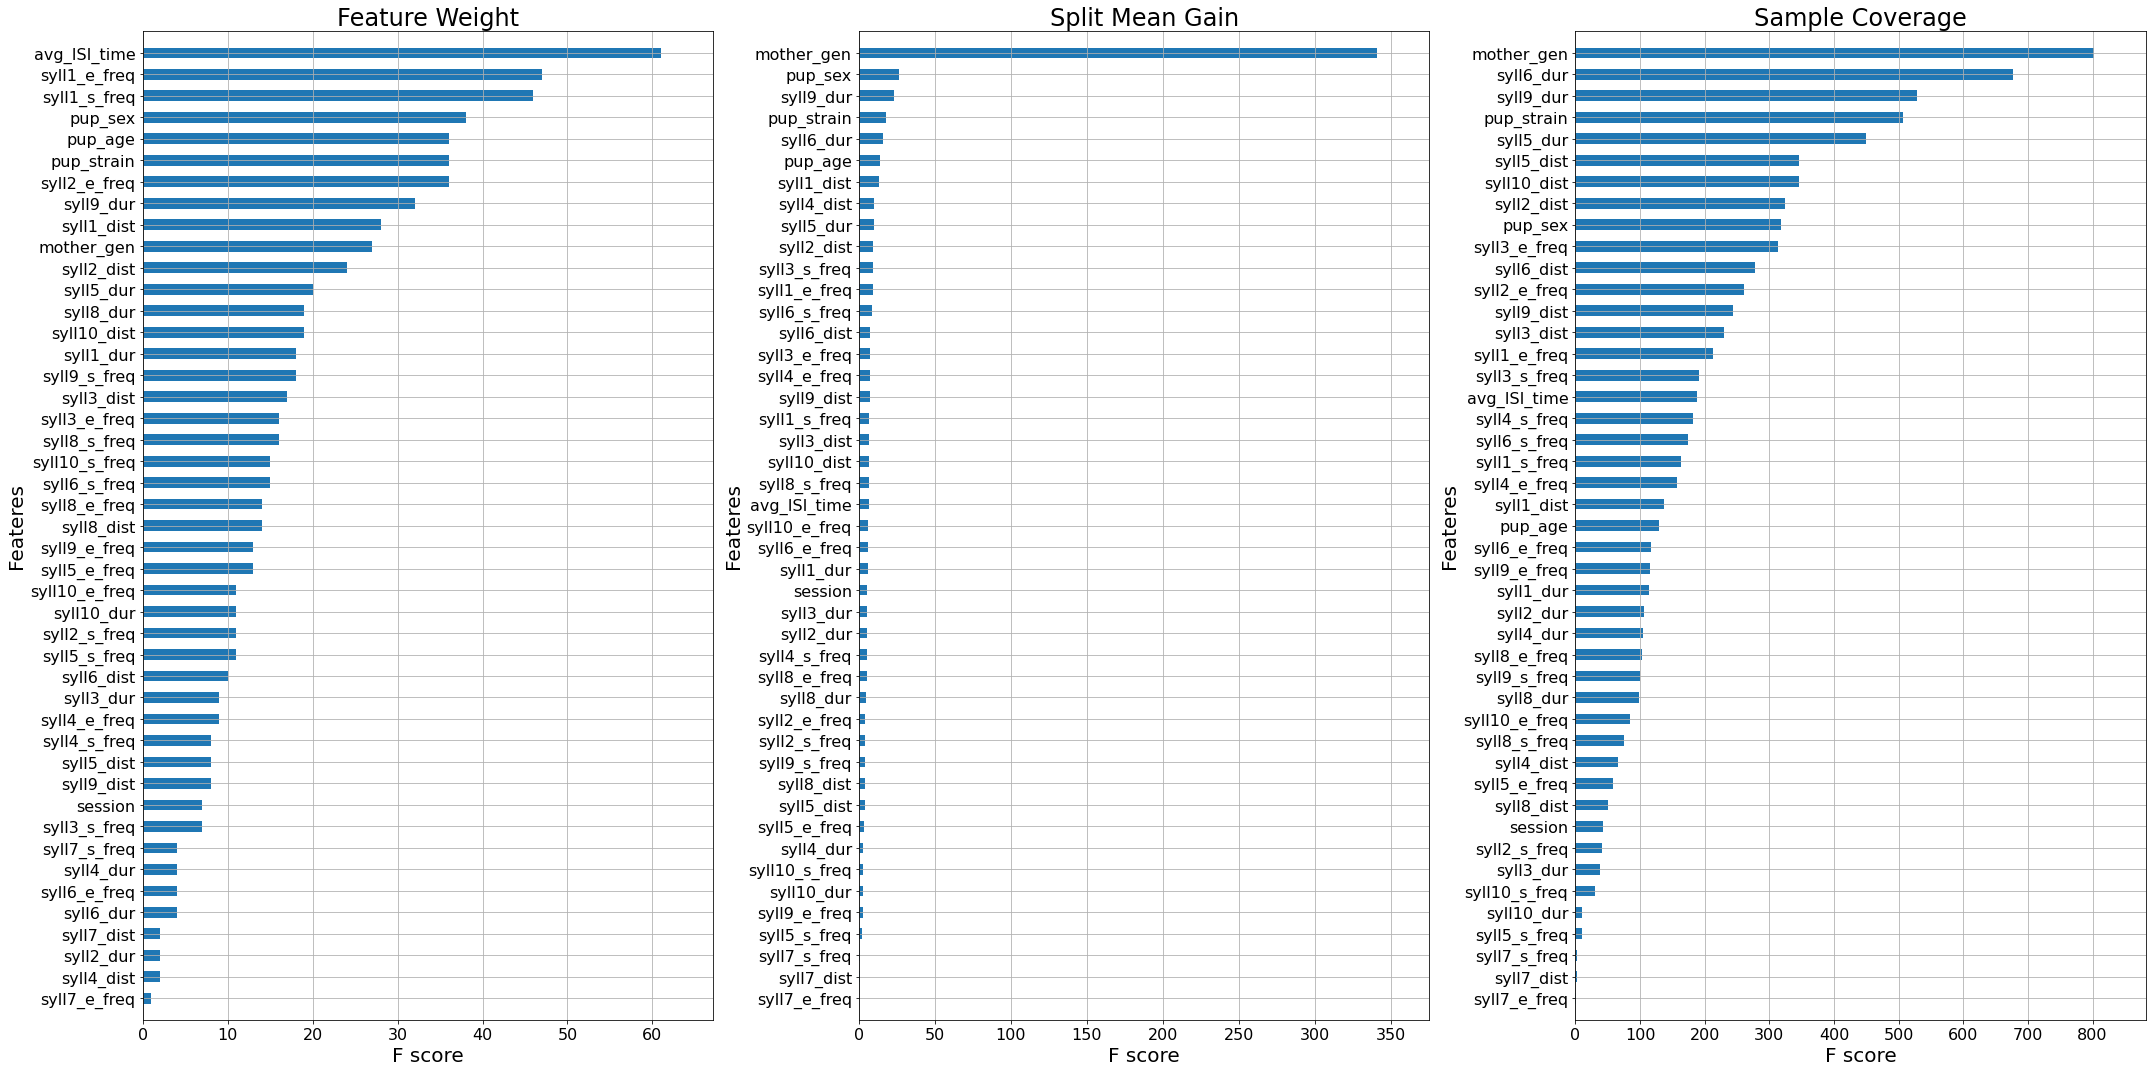

In [ ]:
# PLOT FEATURE IMPORTANCE:

fig, ax = plt.subplots(1, 3, figsize=(30,15))
# plot importances with feature weight

xgb.plot_importance(
    booster=model, 
    importance_type='weight',
    title='Feature Weight',
    show_values=False,
    height=0.5,
    ax=ax[0]
)
ax[0].set_ylabel('Feateres', fontsize=20)
ax[0].set_xlabel('F score', fontsize=20)
ax[0].set_title('Feature Weight', fontsize=24)
ax[0].tick_params(axis='both', which='major', labelsize=16)

# plot importances with split mean gain
xgb.plot_importance(
    booster=model,
    importance_type='gain',
    title='Split Mean Gain',
    show_values=False,
    height=0.5,
    ax=ax[1]
)
ax[1].set_ylabel('Feateres', fontsize=20)
ax[1].set_xlabel('F score', fontsize=20)
ax[1].set_title('Split Mean Gain', fontsize=24)
ax[1].tick_params(axis='both', which='major', labelsize=16)
# plot importances with sample coverage
xgb.plot_importance(
    model,
    importance_type='cover',
    title='Sample Coverage',
    show_values=False,
    height=0.5,
    ax=ax[2]
)
ax[2].set_ylabel('Feateres', fontsize=20)
ax[2].set_xlabel('F score', fontsize=20)
ax[2].set_title('Sample Coverage', fontsize=24)
ax[2].tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/final_project/final_classification/feature_importance.png', dpi=300)
plt.show()

***by using GridSearch (archived below):***

Best model: {'subsample': 0.8, 'reg_lambda': 1, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}



```
# This is formatted as code
```

ARCHIVE - USING GRIDSEARCH TO FIND BEST HYPER-PARAMETERS
---

In [ ]:
#---------------------------------------------------------

# create a default XGBoost classifier
from sklearn.metrics import make_scorer
seed = 1000
model = XGBClassifier(
    random_state=seed, 
    eval_metric=["error", "auc"]
)
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [1, 0.5,0.1, 0.01, 0.001],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [2, 3, 4, 5, 10],
    "n_estimators": [25, 50, 100, 200, 300, 400, 500],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
    "reg_alpha": [0.005, 0.01, 0.05, 0.1, 0.5],
    "colsample_bytree": [0.4, 0.6, 0.8, 1]
}

scoring = {
    'AUC': 'roc_auc',
     'Accuracy': make_scorer(accuracy_score)
}
# create the Kfold object
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds)#, random_state=seed)
# create the grid search object
n_iter=50
grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC",
)
# fit grid search
%time best_model = grid.fit(X_train,y_train)
from sklearn.metrics import confusion_matrix

print(f'Best score: {best_model.best_score_}')
print(f'Best model: {best_model.best_params_}')

pred_test = best_model.predict(X_test)
pred_train = best_model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

# store the winning model in a new variable
xgc = best_model.best_estimator_
# saving the feature names to the model
xgc.get_booster().feature_names = X.columns.to_list()
# PLOT FEATURE IMPORTANCE:
# # Create the feature importances plot
# fig, ax = plt.subplots(1, 3, figsize=(15,5))
# # plot importances with feature weight
# xgb.plot_importance(
#     booster=xgc, 
#     importance_type='weight',
#     title='Feature Weight',
#     show_values=False,
#     height=0.5,
#     ax=ax[0],
# )
# # plot importances with split mean gain
# xgb.plot_importance(
#     booster=xgc,
#     importance_type='gain',
#     title='Split Mean Gain',
#     show_values=False,
#     height=0.5,
#     ax=ax[1]
# )
# # plot importances with sample coverage
# xgb.plot_importance(
#     xgc,
#     importance_type='cover',
#     title='Sample Coverage',
#     show_values=False,
#     height=0.5,
#     ax=ax[2]
# )
# plt.tight_layout()
# plt.show()


# TAKEN FROM EXAMPLE WITHOUT GRID SEARCH:
# retrieve performance metrics
results = xgc.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
# plot auc
ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[0].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[0].legend()
ax[0].set_title('XGBoost AUC-ROC')
ax[0].set_ylabel('AUC-ROC')
ax[0].set_xlabel('N estimators')
# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_title('XGBoost Classification Error')
ax[1].set_ylabel('Classification Error')
ax[1].set_xlabel('N estimators')
plt.show()
plt.tight_layout()


# plot a decision tree from the booster
xgb.plot_tree(booster=xgc, num_trees=0, ax=ax, rankdir='LR')
plt.tight_layout()
plt.show()

CPU times: user 2.91 s, sys: 210 ms, total: 3.12 s
Wall time: 2min 11s
Best score: 0.8399221856054861
Best model: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.5, 'n_estimators': 300, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1}
Train Accuracy:  0.8656126482213439
Test Accuraccy:  0.7492260061919505

Confusion Matrix:
[[ 74 170]
 [ 73 652]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      0.30      0.38       244
         1.0       0.79      0.90      0.84       725

    accuracy                           0.75       969
   macro avg       0.65      0.60      0.61       969
weighted avg       0.72      0.75      0.73       969



AttributeError: ignored

ARCHIVE - TUNE LEARNING RATE (from source 7)
---

In [ ]:
# # XGBoost on Otto dataset, Tune learning_rate and n_estimators
# from pandas import read_csv
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import LabelEncoder
# import matplotlib
# matplotlib.use('Agg')
# from matplotlib import pyplot
# import numpy
# # load data
# # data = read_csv('train.csv')
# # dataset = data.values
# # # split data into X and y
# # X = dataset[:,0:94]
# # y = dataset[:,94]
# # encode string class values as integers
# label_encoded_y = LabelEncoder().fit_transform(y)
# # grid search
# model = XGBClassifier()
# n_estimators = [100, 200, 300, 400, 500]
# learning_rate = [0.0001, 0.001, 0.01, 0.1]
# param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
# grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
# grid_result = grid_search.fit(X, label_encoded_y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
# 	print("%f (%f) with: %r" % (mean, stdev, param))
# # plot results
# scores = numpy.array(means).reshape(len(learning_rate), len(n_estimators))
# for i, value in enumerate(learning_rate):
#     pyplot.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
# pyplot.legend()
# pyplot.xlabel('n_estimators')
# pyplot.ylabel('Log Loss')
# pyplot.savefig('n_estimators_vs_learning_rate.png')